In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import yfinance as yf
from scipy.signal import argrelextrema
# from collections import deque
# from matplotlib.lines import Line2D
import pandas_ta as ta
import ccxt
from datetime import datetime, timedelta
# import plotly.graph_objects as go
# import inspect 
import os


pd.set_option('display.max_rows', None)


In [2]:
exchange = ccxt.binance()
exchange.load_markets()

symbols = exchange.symbols

In [3]:
# ticker = 'BTC-USDT'
# timeframe ='4h'
# use bars[-1] to avoid false signal espeacially in current candle
# because ccxt gives the ongoing candle before they close
# do bars[-3] to get less trades; but better quality
def ccxt_data(symbol='BTC/USDT', timeframe ='1d', limit=100):
    global data
    bars = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    data = pd.DataFrame(bars[:-3], columns=['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
    data['Time'] = pd.to_datetime(data['Time'], unit='ms')
    data.set_index('Time', inplace=True)
    m_symbol = symbol.replace("/","_")
    data.to_csv(f'C:/Users/Grant/Desktop/work_git/work/data/{m_symbol}.csv')
    return data

In [ ]:
def savetocsv(symbol, timeframe, limit):
    # outname = 'name.csv'
    m_symbol = symbol.replace("/","_")
    outname = m_symbol+'_'+timeframe+'_'+limit
    
    outdir = f'./dir/data/{timeframe}'
    if not os.path.exists(outdir):
        os.mkdir(outdir)

    fullname = os.path.join(outdir, outname)    

    df.to_csv(fullname)

In [4]:
# data=ccxt_data()

def calc():
    
    # data=ccxt_data()
    # calc indicator
    data['ta_rsi'] = ta.rsi(data['Close'], length = 14)

    # calc peaks and troughs of close price and the indicator(s)
    coin_peak = argrelextrema(data['Close'].values, np.greater, order=5)[0]
    coin_peaks_df = data.iloc[coin_peak]['Close']

    ta_peak = argrelextrema(data['ta_rsi'].values, np.greater, order=5)[0]
    ta_peaks_df = data.iloc[ta_peak]['ta_rsi']

    coin_trough = argrelextrema(data['Close'].values, np.less, order=5)[0]
    coin_trough_df = data.iloc[coin_trough]['Close']

    ta_trough = argrelextrema(data['ta_rsi'].values, np.less, order=5)[0]
    ta_trough_df = data.iloc[ta_trough]['ta_rsi']

    global peaks_df
    global troughs_df

    peaks = [coin_peaks_df, ta_peaks_df]
    peaks_df = pd.concat(peaks, axis=1)
    peaks_df = peaks_df[(peaks_df.Close.notna()) & (peaks_df.ta_rsi.notna())]

    troughs = [coin_trough_df, ta_trough_df]
    troughs_df = pd.concat(troughs, axis=1)
    troughs_df = troughs_df[(troughs_df.Close.notna()) & (troughs_df.ta_rsi.notna())]

    return peaks_df, troughs_df

# def trough_diff(n=1):

#     diff = troughs_df.diff(n)
#     sig = diff[~((diff > 0).all(1)) & ~((diff < 0).all(1))]
#     return sig

# def peak_diff(n=1):

#     diff = peaks_df.diff(n)
#     sig = diff[~((diff > 0).all(1)) & ~((diff < 0).all(1))]
#     return sig


In [5]:

# peaks_df, troughs_df = calc()

def signal_dates(n=9):
    # peaks_df, troughs_df = calc()

    dates_of_peaks = []
    for i in range(n):
        if i == 0:
            diff = peaks_df.diff(1)
            sig = diff[~((diff > 0).all(1)) & ~((diff < 0).all(1))]
            dates_of_peaks.append(sig.index.values)
            continue
        diff = peaks_df.diff(i)
        sig = diff[~((diff > 0).all(1)) & ~((diff < 0).all(1))]
        dates_of_peaks.append(sig.index.values)

    dates_of_troughs = []
    for i in range(n):
        if i == 0:
            diff = troughs_df.diff(1)
            sig = diff[~((diff > 0).all(1)) & ~((diff < 0).all(1))]
            dates_of_troughs.append(sig.index.values)
            continue
        diff = troughs_df.diff(i)
        sig = diff[~((diff > 0).all(1)) & ~((diff < 0).all(1))]
        dates_of_troughs.append(sig.index.values)

    global sell
    sell = []
    for list in dates_of_peaks:
        for i in list:
            if i not in sell:
                # i = i + np.timedelta64(4, 'h') # adj sell date
                sell.append(i)

    global buy
    buy = []
    for list in dates_of_troughs:
        for i in list:
            if i not in buy:
                # i = i + np.timedelta64(4, 'h')
                buy.append(i)
                

    sell.sort()
    buy.sort()

    return sell, buy



In [6]:
# def bsm_allah(ticker='BTC/USDT',timeframe='4h',limit=100):
    
#     ccxt_data(ticker,timeframe,limit)
#     calc()
#     signal_dates()
#     # sell, buy = signal_dates()

#     # ticker = str(inspect.signature(bsm_allah).parameters['ticker'])
#     # timeframe = str(inspect.signature(bsm_allah).parameters['timeframe'])

#     print(f'last buy signal was {buy[-1]}')
#     # global buy_list_dates 
#     # buy_list_dates = []
#     # buy_list_dates.insert(len(buy_list_dates),buy[-1])

#     print(f'last sell signal was {sell[-1]}')
#     # global sell_list_dates 
#     # sell_list_dates = []
#     # sell_list_dates.insert(len(sell_list_dates),sell[-1])
     
# bsm_allah('EOS/BTC','1d',150)

In [7]:
# import pairs

t = 'BUSD'
pairs = []

unwanted = ["UST","ETH/","BKRW","VAI","RUB","NGN","DAI","BIDR","BEAR", "BULL", "PAX", "TUSD", "UMA", "USDC", "USDP", "BUSD/", "EUR", "USDT", "GBP", "TRY", "AUD","BRL", "BVND"]

for s in symbols:
    if (t in s):
        pairs.append(s)

pairs=[n for n in pairs if all(m not in n for m in unwanted)]


test_pairs = ["GLMR/BUSD", "AAVE/ETH"]

In [8]:
from IPython.core.display import display, HTML


# always put the list out of the loop or everthing will be wiped out each turn
rows = []
# timeframe = '4h'

for symbol in pairs:

    
    ccxt_data(symbol,'2h',111)
    calc()
    signal_dates()
    # remeber if you get "IndexError: list index out of range" while using buy[-1]
    # that means buy, sell_date list is empty so no signals yet

    # sell_date=min(sell_date, key=lambda d: (d - buy[-1])>0)
    
    if buy:
        # data viewer wont work if min default is not datetime


        # buy.append(buy[-1] + timedelta(hours=4))
        # sell_date.append(sell_date[-1] + timedelta(hours=4))

        # buy[-1]=buy[-1]+np.timedelta64(4, 'h')
        # adjsell=sell_date[-1]+np.timedelta64(4, 'h')

        # buy.insert(-1,buy[-1]+np.timedelta64(8, 'h'))

        sell_date = min((dt for dt in sell if dt > buy[-1]),default=buy[-1])
        # sell_date = sell_date + np.timedelta64(8, 'h')

        if sell_date > buy[-1]:
            trade_on = False
            # profit=((data.loc[sell_date[-1]]['Close']/data.loc[buy[-1]]['Close'])-1)*100
             
            profit_since_buy = ((data.loc[sell_date]['Close']/data.loc[buy[-1]]['Close'])-1)*100
            duration=sell_date - buy[-1]
            selldate= sell_date
           

            if (peaks_df.size != 0):
                try:
                    prev_peak=((peaks_df.Close[-1]/data.loc[buy[-1]]['Close'])-1)*100
                except:
                    prev_peak=0
                    print('prev_peak shit', symbol)
            
            else:
                prev_peak = 0
                print(f'peaks_df size is {peaks_df.size} =0 (no prev peak) {symbol}')
                print('probably token nexiste pa')

        else:
            trade_on = True
            profit_since_buy = ((data.iloc[-1]['Close']/ data.loc[buy[-1]]['Close'])-1)*100
            duration=0 # df column must be same type
            selldate = sell_date # its buy[-1] bcase of default arg in min

            if (peaks_df.size != 0):
                try:
                    prev_peak=((peaks_df.Close[-1]/data.loc[buy[-1]]['Close'])-1)*100
                except:
                    prev_peak=0
                    print('prev_peak shit', symbol)
            else:
                prev_peak = 0
                print(f'peaks_df size is {peaks_df.size} =0 (no prev peak) {symbol}')
                print('probably token nexiste pa')

        

        rows.append([symbol, buy[-1], selldate, trade_on, profit_since_buy,prev_peak,duration])

        df = pd.DataFrame(rows, columns=["A", "Buy","Sell", "trade_on","profit_percent","prev_peak","duration"])

        df['link'] = df['A'].apply(lambda x: f'<a href="https://www.tradingview.com/chart/UOC7kIDx/?symbol=BINANCE%3A{x.replace("/","")}">{x}</a>')

    else:
        print('no buy yet for ', symbol)



In [15]:
display(HTML(df.to_html(escape=False)))


,A,Buy,Sell,trade_on,profit_percent,prev_peak,duration,link
0,1INCH/BUSD,2022-01-16 12:00:00,2022-01-16 20:00:00,False,2.214793,-8.315921,28800000000000 nanoseconds,1INCH/BUSD
1,AAVE/BUSD,2022-01-17 16:00:00,2022-01-18 00:00:00,False,6.986117,5.553068,28800000000000 nanoseconds,AAVE/BUSD
2,ACH/BUSD,2022-01-18 10:00:00,2022-01-19 00:00:00,False,6.835744,6.835744,50400000000000 nanoseconds,ACH/BUSD
3,ACM/BUSD,2022-01-18 14:00:00,2022-01-18 22:00:00,False,3.324273,3.324273,28800000000000 nanoseconds,ACM/BUSD
4,ADA/BUSD,2022-01-18 18:00:00,2022-01-19 00:00:00,False,5.775922,5.775922,21600000000000 nanoseconds,ADA/BUSD
5,ADX/BUSD,2022-01-18 16:00:00,2022-01-18 16:00:00,True,1.532399,9.063047,0,ADX/BUSD
6,AERGO/BUSD,2022-01-18 12:00:00,2022-01-19 00:00:00,False,4.490741,4.490741,43200000000000 nanoseconds,AERGO/BUSD
7,AGLD/BUSD,2022-01-17 02:00:00,2022-01-17 06:00:00,False,5.886681,-1.471670,14400000000000 nanoseconds,AGLD/BUSD
8,AION/BUSD,2020-11-09 14:00:00,2020-11-10 00:00:00,False,14.533965,14.533965,36000000000000 nanoseconds,AION/BUSD
9,ALCX/BUSD,2022-01-15 08:00:00,2022-01-15 14:00:00,False,1.493506,-17.759740,21600000000000 nanoseconds,ALCX/BUSD


In [10]:
# sdflkqjsdfkjqsdpjfqsdpfj


In [11]:
# # test strategy

# # f = open('C:\\Users\\Grant\\virenv\\ttm\\txts\\usdt.txt', 'r')
# # content = f.read()

# from IPython.core.display import display, HTML


# # always put the list out of the loop or everthing will be wiped out each turn
# rows = []

# for symbol in pairs:

#     try:
#         ccxt_data(symbol,'4h',111)
#         calc()
#         signal_dates()
#         # remeber if you get "IndexError: list index out of range" while using buy[-1]
#         # that means buy, sell list is empty so no signals yet
        
#         # sellafterbuy=min(sell, key=lambda d: (d - buy[-1])>0)

#         sellafterbuy = min(dt for dt in sell if dt > buy[-1])


#     #   if sellafterbuy:
#         if sell[-1] > buy[-1]:
#             trade_on = False
#             # percentage=((data.loc[sell[-1]]['Close']/data.loc[buy[-1]]['Close'])-1)*100
#             percentage=((data.loc[sellafterbuy]['Close']/data.loc[buy[-1]]['Close'])-1)*100
#             duration=sellafterbuy - buy[-1]
#             last_peak=((peaks_df.Close[-2]/data.loc[buy[-1]]['Close'])-1)*100
#             selldate= sellafterbuy
#         else:
#             trade_on = True
#             percentage= 0
#             duration=buy[-1]
#             last_peak=((peaks_df.Close[-1]/data.loc[buy[-1]]['Close'])-1)*100
#             selldate = 0

#         # if sellafterbuy > buy[-1]:
#         #     trade_on = False
#         #     # percentage=((data.loc[sell[-1]]['Close']/data.loc[buy[-1]]['Close'])-1)*100
#         #     percentage=((data.loc[sellafterbuy]['Close']/data.loc[buy[-1]]['Close'])-1)*100
#         #     duration=sellafterbuy - buy[-1]
#         #     last_peak=((peaks_df.Close[-2]/data.loc[buy[-1]]['Close'])-1)*100
#         # else:
#         #     trade_on = True
#         #     percentage= 0
#         #     duration=buy[-1]
#         #     last_peak=((peaks_df.Close[-1]/data.loc[buy[-1]]['Close'])-1)*100


#         rows.append([symbol, buy[-1], selldate, trade_on, percentage,last_peak,duration])
        
#         df = pd.DataFrame(rows, columns=["A", "Buy","Sell", "trade_on","profit_percent","last_peak","duration"])

#         df['link'] = df['A'].apply(lambda x: f'<a href="https://www.tradingview.com/chart/UOC7kIDx/?symbol=BINANCE%3A{x.replace("/","")}">{x}</a>')
        

#     except:
#         print(f"{symbol}")
        

# # TypeError: '>' not supported between instances of 'NoneType' and 'NoneType'
# # ta_peak = argrelextrema(data['ta_rsi'].values, np.greater, order=5)[0]
# # the error happend at one/eth so i looked in trading view
# # it had no rsi so thats the problem





No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


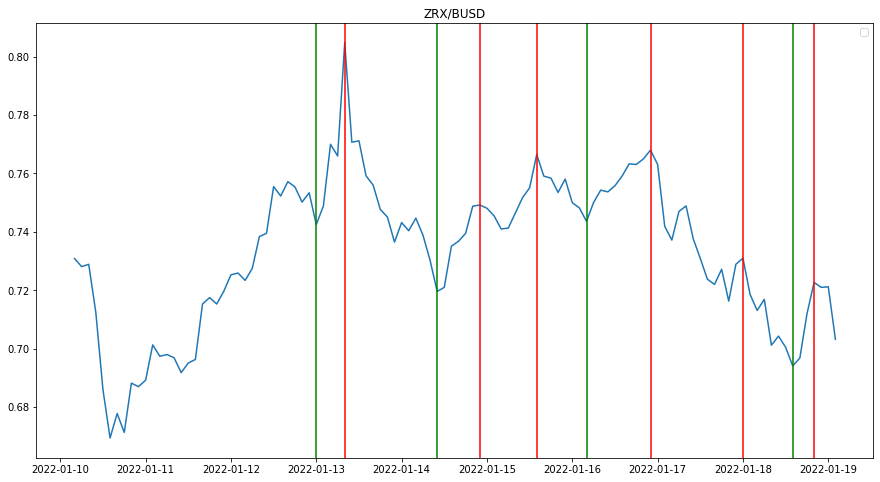

In [12]:
plt.figure(figsize=(15, 8))
plt.plot(data['Close'], zorder=0)

# sell, buy = signal_dates()

for xc in buy:
    plt.axvline(x=xc,color='g')

for xc in sell:
    plt.axvline(x=xc,color='r')

# draw the last call only
# b = buy[-1]
# plt.axvline(x=b,color='g')

# s = sell[-1]
# plt.axvline(x=s,color='r')
plt.title(symbol)
plt.legend()
plt.show()

In [13]:
s=ta.ha(data['Open'],data['High'],data['Low'],data['Close'])
s

,HA_open,HA_high,HA_low,HA_close
Time,,,,
2022-01-10 04:00:00,0.728550,0.734700,0.726200,0.729500
2022-01-10 06:00:00,0.729025,0.732800,0.727300,0.729750
2022-01-10 08:00:00,0.729388,0.729388,0.722400,0.727100
2022-01-10 10:00:00,0.728244,0.730000,0.712400,0.719800
2022-01-10 12:00:00,0.724022,0.724022,0.684300,0.699275
2022-01-10 14:00:00,0.711648,0.711648,0.654300,0.674275
2022-01-10 16:00:00,0.692962,0.692962,0.661700,0.675125
2022-01-10 18:00:00,0.684043,0.684043,0.669400,0.673400
2022-01-10 20:00:00,0.678722,0.689200,0.669000,0.680100


In [14]:
# l = [0,2,3,5,8,7,4,5,2,1,5]

# dff = pd.DataFrame(l[:-2])

# dff